## UFO Sightings Implementation and Operations Lab

The goal of this notebook is to train and deploy our model into SageMaker online hosting with 1 variant. 

What we plan on accompishling is the following:  
1. [Load dataset onto Notebook instance memory from S3](#Step-1:-Load-the-data-from-Amazon-S3)  
1. [Cleaning, transforming and preparing the dataset](#Step-2:-Cleaning,-transforming-and-preparing-the-dataset)   
1. [Create and train our model (Linear Learner)](#Step-4:-Creating-and-training-our-model-(Linear-Learner))  
1. [Deploying the model into SageMaker hosting](#Step-4:-Deploying-the-model-into-SageMaker-hosting)  


First let's go ahead and import all the needed libraries.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Loading the data to and from Amazon S3
Let's get the UFO sightings data that is stored in S3 and load it into memory.

In [2]:
# # execute this on aws sagemaker
# role = get_execution_role()

# use this if running sagemaker locally
def resolve_sm_role():
    client = boto3.client('iam', region_name='us-east-2')
    response_roles = client.list_roles(
        PathPrefix='/',
        # Marker='string',
        MaxItems=999
    )
    for role in response_roles['Roles']:
        if role['RoleName'].startswith('AmazonSageMaker-ExecutionRole-'):
            print('Resolved SageMaker IAM Role to: ' + str(role))
            return role['Arn']
    raise Exception('Could not resolve what should be the SageMaker role to be used')

# this is the role created by sagemaker notebook on aws
role_arn = resolve_sm_role()
print(role_arn)
role=role_arn

Resolved SageMaker IAM Role to: {'Path': '/service-role/', 'RoleName': 'AmazonSageMaker-ExecutionRole-20200208T092301', 'RoleId': 'AROA4UGSQ27FVTPNSTGPW', 'Arn': 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200208T092301', 'CreateDate': datetime.datetime(2020, 2, 8, 15, 23, 34, tzinfo=tzlocal()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Effect': 'Allow', 'Principal': {'Service': 'sagemaker.amazonaws.com'}, 'Action': 'sts:AssumeRole'}]}, 'Description': 'SageMaker execution role created from the SageMaker AWS Management Console.', 'MaxSessionDuration': 3600}
arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200208T092301


In [3]:
! echo $PWD
import sys
import os
print(os.getcwd())
curent_dir = os.getcwd() + "/acg-course/Chapter9"
print(curent_dir)

/home/ec2-user/SageMaker/acg-course/Chapter9
/home/ec2-user/SageMaker/acg-course/Chapter9
/home/ec2-user/SageMaker/acg-course/Chapter9/acg-course/Chapter9


In [ ]:
# ! pip install --prefix {sys.prefix} s3fs

In [4]:
import os.path
bucket = 'md-ml-labs-bucket'
prefix = 'ufo_dataset'
print(os.getcwd())

# # use this when in vscode
# data_path = os.path.join(curent_dir, 'ufo_fullset.csv')

# # use this when in browser
data_path = os.path.join(os.getcwd(), 'ufo_fullset.csv')
print(data_path)


/home/ec2-user/SageMaker/acg-course/Chapter9
/home/ec2-user/SageMaker/acg-course/Chapter9/ufo_fullset.csv


### upload dataset to s3

In [5]:
# this will take a few seconds
import sagemaker as sage
sess = sage.Session()
s3_data_path = sess.upload_data(
    path=data_path, 
    bucket=bucket, 
    key_prefix=prefix)
print(s3_data_path)


s3://md-ml-labs-bucket/ufo_dataset/ufo_fullset.csv


### read dataset from s3 using pandas - method 1 - working

In [6]:
# reference:
# https://dluo.me/s3databoto3
s3_client = boto3.client('s3')
obj = s3_client.get_object(
    Bucket=bucket,
    Key='ufo_dataset/ufo_fullset.csv'
)
df = pd.read_csv(obj['Body'])
df.head()


,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


In [7]:
import sys
! which python
! which pip

/home/ec2-user/anaconda3/bin/python
/home/ec2-user/anaconda3/bin/pip


In [8]:
# ! /home/ec2-user/anaconda3/bin/pip install --prefix {sys.prefix} botocore

In [9]:
# ! /home/ec2-user/anaconda3/bin/pip install --prefix {sys.prefix} s3fs

### read dataset from s3 using pandas - method 2 - not working due to s3fs missing

<hr>

In [10]:
# import boto3
# # import s3fs

# # role = get_execution_role()
# bucket='md-ml-labs-bucket'
# sub_folder = 'ufo_dataset'
# data_key = 'ufo_fullset.csv'
# data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)

# df = pd.read_csv(data_location, low_memory=False)
# df.head()

## Step 2: Cleaning, transforming and preparing the dataset
This step is so important. It's crucial that we clean and prepare our data before we do anything else.

Let's go ahead and start preparing our dataset by transforming some of the values into the correct data types. Here is what we are going to take care of.
1. Convert the `reportedTimestamp` and `eventDate` to a datetime data types.
1. Convert the `shape` and `weather` to a category data type.
1. Map the `physicalEvidence` and `contact` from 'Y', 'N' to `0`, `1`.
1. Convert the `researchOutcome` to a category data type (target attribute).

Let's also drop the columns that are not important. 
1. We can drop `sighting` becuase it is always 'Y' or Yes. 
1. Let's drop the `firstName` and `lastName` becuase they are not important in determining the `researchOutcome`.
1. Let's drop the `reportedTimestamp` becuase when the sighting was reporting isn't going to help us determine the legitimacy of the sighting.
1. We would need to create some sort of buckets for the `eventDate` and `eventTime`, like seasons for example, but since the distribution of dates is pretty even, let's go ahead and drop them.

Finally, let's apply one-hot encoding
1. We need to one-hot both the `weather` attribute and the `shape` attribute. 
1. We also need to transform or map the researchOutcome (target) attribute into numeric values. This is what the alogrithm is expecting. We can do this by mapping unexplained, explained, and probable to 0, 1, 2.

# Cleaning

In [11]:
# Replace the missing values with the most common shape
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])
df['reportedTimestamp'].head()


0    1977-04-04T04:02:23.340Z
1    1982-11-22T02:06:32.019Z
2    1992-12-07T19:06:52.482Z
3    2011-02-24T21:06:34.898Z
4    1991-03-09T16:18:45.501Z
Name: reportedTimestamp, dtype: object

In [12]:

df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['reportedTimestamp'].head()


0   1977-04-04 04:02:23.340000+00:00
1   1982-11-22 02:06:32.019000+00:00
2   1992-12-07 19:06:52.482000+00:00
3   2011-02-24 21:06:34.898000+00:00
4   1991-03-09 16:18:45.501000+00:00
Name: reportedTimestamp, dtype: datetime64[ns, UTC]

In [13]:
df['eventDate'] = pd.to_datetime(df['eventDate'])

In [14]:
type(df['shape'][1])

str

In [15]:
df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

In [16]:
type(df['shape'][1])

str

In [17]:
df['physicalEvidence'].head()

0    N
1    Y
2    N
3    N
4    N
Name: physicalEvidence, dtype: object

In [18]:
df['physicalEvidence'] = df['physicalEvidence'].replace({'Y': 1, 'N': 0})
df['contact'] = df['contact'].replace({'Y': 1, 'N': 0})

In [19]:
df['physicalEvidence'].head()

0    0
1    1
2    0
3    0
4    0
Name: physicalEvidence, dtype: int64

In [20]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [21]:
df['researchOutcome'] = df['researchOutcome'].astype('category')
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [22]:
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


# One Hot Encoding

In [23]:
# Let's one-hot the weather and shape attribute
df = pd.get_dummies(df, columns=['weather', 'shape'])

In [24]:
# Let's replace the researchOutcome values with 0, 1, 2 for Unexplained, Explained, and Probable
df['researchOutcome'] = df['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

In [26]:
display(df.head(30))
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,weather_partly cloudy,weather_rain,weather_snow,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,65,1,33.916389,-118.351667,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,80,1,33.669444,-117.822222,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
7,33,1,44.716667,-75.516667,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8,22,1,40.866667,-124.081667,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9,72,1,47.130278,-119.276944,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


(18000, 23)

<hr>

---

## Step 3: Creating and training our model (Linear Learner)

Let's evaluate the Linear Learner algorithm as well. Let's go ahead and randomize the data again and get it ready for the Linear Leaner algorithm. We will also rearrange the columns so it is ready for the algorithm (it expects the first column to be the target attribute)

In [27]:
len(df)

18000

In [28]:
np.random.seed(0)

In [29]:
# create an array with len(df) lenght filled with random values between 0 and 1 
rand_split = np.random.rand(len(df))
rand_split

array([0.5488135 , 0.71518937, 0.60276338, ..., 0.53561083, 0.35458205,
       0.93578099])

In [30]:
# get a list of booleans, when number is < 0.8 the element is True
train_list = rand_split < 0.8

val_list = (rand_split >= 0.8) & (rand_split < 0.9)

test_list = rand_split >= 0.9

In [31]:
test_list

array([False, False, False, ..., False, False,  True])

In [32]:
# This dataset will be used to train the model.
data_train = df[train_list]
data_train.shape

(14430, 23)

In [33]:
# This dataset will be used to validate the model.
data_val = df[val_list]
data_val.shape

(1773, 23)

In [34]:
# This dataset will be used to test the model.
data_test = df[test_list]
data_test.shape

(1797, 23)

In [35]:
# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').as_matrix()
train_y = data_train['researchOutcome'].as_matrix()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
pd.DataFrame(data=train_X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,4.0,1.0,47.329444,-122.578889,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,1.0,52.664913,-1.034894,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49.0,1.0,38.951667,-92.333889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,1.0,41.496944,-71.367778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.0,1.0,47.606389,-122.330833,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pd.DataFrame(data=train_y).head()

,0
0,1
1,1
2,1
3,1
4,1


In [38]:
val_X = data_val.drop(columns='researchOutcome').as_matrix()
val_y = data_val['researchOutcome'].as_matrix()

test_X = data_test.drop(columns='researchOutcome').as_matrix()
test_y = data_test['researchOutcome'].as_matrix()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


# create recordIO file for the training data and upload it to S3.

In [39]:
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

# initialise a BytesIO object
f = io.BytesIO()

# writes a numpy array to a dense tensor. the dense tensor is f
smac.write_numpy_to_dense_tensor(
    file=f, 
    array=train_X.astype('float32'), 
    labels=train_y.astype('float32'))

# position the cursor to position 0
f.seek(0)

# reference:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_fileobj
# upload the filelike to s3
boto3.Session().resource('s3').Bucket(bucket).Object('implementation_operations_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)


training_recordIO_protobuf_location = 's3://{}/implementation_operations_lab/linearlearner_train/{}'.format(bucket, train_file)
print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

The Pipe mode recordIO protobuf training data: s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data


# create recordIO file for the validation data and upload it to S3

In [40]:
# we do the same stuff as with the training data

# name of the protobuf file with validation data
validation_file = 'ufo_sightings_validatioin_recordIO_protobuf.data'

# initialise a BytesIO object
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(
    file=f, 
    array=val_X.astype('float32'), 
    labels=val_y.astype('float32'))

# position the cursor to 0
f.seek(0)

# write the file to s3 as protobuf
boto3.Session().resource('s3').Bucket(bucket).Object('implementation_operations_lab/linearlearner_validation/{}'.format(validation_file)).upload_fileobj(f)


validate_recordIO_protobuf_location = 's3://{}/implementation_operations_lab/linearlearner_validation/{}'.format(bucket, validation_file)
print('The Pipe mode recordIO protobuf validation data: {}'.format(validate_recordIO_protobuf_location))

The Pipe mode recordIO protobuf validation data: s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


---
# Linear Learner
Alright we are good to go for the Linear Learner algorithm. Let's get everything we need from the ECR repository to call the Linear Learner algorithm.

In [41]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "1")
print(container)

404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:1


In [42]:
# training job name
job_name = 'ufo-linear-learner-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Here is the job name {}'.format(job_name))

Here is the job name ufo-linear-learner-job-20200208192848


In [45]:
# Here is where the model-artifact will be stored
output_location = 's3://{}/implementation_operations_lab/linearlearner_output'.format(bucket)
print(output_location)

s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_output


In [44]:
print('The feature_dim hyperparameter needs to be set to {} because we have 22 features (columns)'.format(data_train.shape[1] - 1))

The feature_dim hyperparameter needs to be set to 22 because we have 22 features (columns)


# Estimator

reference:  
https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html  
https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html  
https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html

In [46]:
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(
    image_name=container,
    role=role,
    train_instance_count=1, 
    train_instance_type= 'ml.c4.8xlarge', #'ml.c4.8xlarge', # 'ml.c4.4xlarge',
    output_path=output_location,
    sagemaker_session=sess,
    input_mode='Pipe')

# Setup the hyperparameters
linear.set_hyperparameters(
    feature_dim=22,
    predictor_type='multiclass_classifier',
    num_classes=3
    # add optimized hyperparmeters here 
    # add optimized hyperparmeters here 
    # add optimized hyperparmeters here 
    # add optimized hyperparmeters here 
    # add optimized hyperparmeters here 
    # add optimized hyperparmeters here
    )

# Fit

In [47]:
print(training_recordIO_protobuf_location)
print(validate_recordIO_protobuf_location)

s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_train/ufo_sightings_train_recordIO_protobuf.data
s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_validation/ufo_sightings_validatioin_recordIO_protobuf.data


In [48]:
# Launch a training job. This method calls the CreateTrainingJob API call
linear.fit(
    inputs= {
        'train': training_recordIO_protobuf_location,
        'validation': validate_recordIO_protobuf_location}, 
    job_name=job_name)

2020-02-08 19:35:51 Starting - Starting the training job...
2020-02-08 19:35:53 Starting - Launching requested ML instances...
2020-02-08 19:36:49 Starting - Preparing the instances for training......
2020-02-08 19:37:47 Downloading - Downloading input data
2020-02-08 19:37:47 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[02/08/2020 19:38:06 INFO 140134096791360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto'

In [50]:
print('MODEL OUTPUT: {}/{}/output/model.tar.gz'.format(output_location, job_name))

MODEL OUTPUT: s3://md-ml-labs-bucket/implementation_operations_lab/linearlearner_output/ufo-linear-learner-job-20200208192848/output/model.tar.gz


---

## Step 4: Deploying the model into SageMaker hosting

Next, let's deploy the model into SageMaker hosting onto a single m4 instance. We can then use this instance to test the model with the test data that we help out at the beginning of the notebook. We can then evaluate things like accuracy, precision, recall, and f1 score. 

We can use some fancy libraries to build out a confusion matrix/heatmap to see how accurate our model is. 

# Deploy

reference:  
http://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html

In [51]:
multiclass_predictor = linear.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge')

-----------!

In [53]:
multiclass_predictor

# Evaluate

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [55]:
test_X

array([[22.  ,  1.  , 40.87, ...,  0.  ,  0.  ,  0.  ],
       [79.  ,  1.  , 39.06, ...,  1.  ,  0.  ,  0.  ],
       [86.  ,  1.  , 28.7 , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [33.  , 10.  , 38.18, ...,  0.  ,  0.  ,  0.  ],
       [83.  , 10.  , 42.08, ...,  0.  ,  0.  ,  0.  ],
       [38.  , 10.  , 29.88, ...,  0.  ,  0.  ,  0.  ]])

In [57]:
from sagemaker.predictor import json_deserializer, csv_serializer

multiclass_predictor.content_type = 'text/csv'
multiclass_predictor.serializer = csv_serializer
multiclass_predictor.deserializer = json_deserializer


results = multiclass_predictor.predict(test_X)

In [61]:
results

{'predictions': [{'score': [0.13032124936580658,
    0.8183549046516418,
    0.051323890686035156],
   'predicted_label': 1.0},
  {'score': [0.07452879846096039, 0.25704529881477356, 0.6684258580207825],
   'predicted_label': 2.0},
  {'score': [0.005749559495598078, 0.9926686882972717, 0.0015817148378118873],
   'predicted_label': 1.0},
  {'score': [0.007307505235075951, 0.9902615547180176, 0.0024310024455189705],
   'predicted_label': 1.0},
  {'score': [0.8216446042060852, 0.1702437698841095, 0.008111626841127872],
   'predicted_label': 0.0},
  {'score': [0.00756115885451436, 0.9902360439300537, 0.002202772069722414],
   'predicted_label': 1.0},
  {'score': [0.006919755134731531, 0.9916682839393616, 0.0014119807165116072],
   'predicted_label': 1.0},
  {'score': [0.00465168384835124, 0.9941902160644531, 0.0011581358266994357],
   'predicted_label': 1.0},
  {'score': [0.006087476387619972, 0.9922919869422913, 0.0016206060536205769],
   'predicted_label': 1.0},
  {'score': [0.1101875454

In [64]:
predictions = []
predictions += [r['predicted_label'] for r in results['predictions']]

In [66]:
predictions

[1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0

In [67]:
predictions = np.array(predictions)

In [68]:
predictions

array([1., 2., 1., ..., 1., 1., 1.])

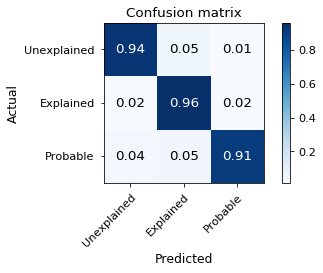

In [82]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_y
y_pred = predictions

class_names = np.array(['Unexplained', 'Explained', 'Probable'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    y_test, 
    y_pred, 
    classes=class_names,
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [70]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score


In [ ]:
y_test = data_test['researchOutcome']

In [71]:
y_test

array([1, 2, 1, ..., 1, 1, 1])

In [ ]:
y_pred = predictions

In [72]:
y_pred

array([1., 2., 1., ..., 1., 1., 1.])

reference:  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [77]:
(precision, recall, f1_score, support) = precision_recall_fscore_support(
    y_true=y_test, 
    y_pred=y_pred, 
    average='macro', 
    labels=np.unique(y_pred))

In [78]:
acc = accuracy_score(y_test, y_pred)

In [79]:
acc

0.9499165275459098

In [80]:
print('Accuracy is: {}'.format(acc))
print('Precision is: {}'.format(precision))
print('Recall is: {}'.format(recall))
print('F1 score is: {}'.format(f1_score))

Accuracy is: 0.9499165275459098
Precision is: 0.9127438555359534
Recall is: 0.9365168251900394
F1 score is: 0.9241429254888969


# Invoke Endpoint

In [91]:
payload = "45.0, 10.0,38.5816667,-121.49333329999999,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.1,1.1"
print(payload)

45.0, 10.0,38.5816667,-121.49333329999999,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.1,1.1


In [92]:
ENDPOINT_NAME = "ufo-linear-learner-job-20200208192848"

sm_runtime_client = boto3.client('runtime.sagemaker')

response = sm_runtime_client.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType='text/csv',
    Body=payload)

print(response)

{'ResponseMetadata': {'RequestId': '2740b98a-03f8-4692-8149-0cd939814e05', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2740b98a-03f8-4692-8149-0cd939814e05', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Sat, 8 Feb 2020 20:23:45 GMT', 'content-type': 'application/json', 'content-length': '118'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f5fa42fb400>}


In [93]:
import json

result = json.loads(response['Body'].read().decode())
print(result)

{'predictions': [{'score': [0.38330313563346863, 0.0005813241587020457, 0.6161155104637146], 'predicted_label': 2.0}]}


In [95]:
pred = int(result['predictions'][0]['predicted_label'])

if(pred == 0):
    print('Unexplained')
if(pred == 1):
    print('Explained')
if(pred == 2):
    print('Probable')

Probable


# Cleanup

In [98]:
import boto3

sm_client = boto3.client('sagemaker')
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

{'ResponseMetadata': {'RequestId': 'fa9616a5-042a-466c-980e-a763e2e4ec08',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fa9616a5-042a-466c-980e-a763e2e4ec08',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 08 Feb 2020 20:32:17 GMT'},
  'RetryAttempts': 0}}